# **ch.09 텍스트를 위한 인공 신경망**  
## 09-2 순환 신경망으로 IMDB 리뷰 분류하기  
### 풀어야 할 문제:  
> ### keras API를 사용하여 IMDB review data를 classify하는 RNN model을 만들어라

<br/>

### *IMDB 리뷰 데이터셋*  
IMDB review data set
+  영화 database인 imdb.com에서 수집한 리뷰를 감상평에 따라 긍정과 부정으로 분류해 놓은 data set
+ 50,000개의 sample로 이루어져 있음
  + train set: 25,000
  + test set: 25,000

<br/>

natural language processing (NLP):  
computer를 사용해 사람의 언어를 처리하는 분야  
ex) 음성 인식, 기계 번역, 감성 분석  
IMDB review를 감상평에 따라 classify하는 것은 감성 분석에 해당  


NLP에서는 train data를 종종 corpus(말뭉치)라고 함  
&rarr; IMDB review data set은 하나의 corpus

<br/>

NLP를 수행할 때, text 자체를 neural network에 전달하지는 않음  
computer에서 처리하는 모든 것은 number로 이루어진 data  
앞서 다루었던 image data도 결국 integer로 이루어진 pixel value였음


text data의 경우 word를 number data로 바꾸는 방법을 사용하는데, 일반적인 방법은 data에 등장하는 word마다 고유한 integer를 부여하는 것  
이 때, word에 mapping되는 integer는 word의 meaning이나 size와 관련 없음  
$\therefore$ word에 mapping되는 integer 사이에는 어떠한 relationship이 없음  
일반적으로 english sentence는 모두 lower case(소문자)로 바꾸고 punctuation(구두점)을 삭제한 후 space를 기준으로 분리함  
이렇게 분리된 word를 token이라고 함  
&rarr; 하나의 sample(sequence)은 여러 개의 token으로 이루어져 있고, 1개의 token이 하나의 timestep에 해당


token에 assign하는 integer 중 몇 가지는 특정한 용도로 reserve되어 있는 경우가 있음

<br/>

IMDB review data set은 english sentence이지만, tensorflow에는 이미 integer로 변환된 data가 있음


`tensorflow.keras.datasets` package 아래 `imdb` module로 data 불러오기  
`num_words` parameter를 `500`으로 지정하여 data set에서 가장 자주 등장하는 word 500개만 사용

In [1]:
from tensorflow.keras.datasets import imdb

(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

train set과 test set의 shape 확인

In [2]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


IMDB review text는 length가 제각각임  
&rarr; 고정 크기의 2 dimension array에 담기는 것보다 review마다 별도의 list로 담아야 memory를 효율적으로 사용할 수 있음  
$\therefore$ 1 dimension array  
$\therefore$ 이 data는 개별 review를 담은 python list object로 이루어진 numpy array

<br/>

첫 번째 review의 length 확인

In [3]:
print(len(train_input[0]))

218


첫 번째 review의 length는 218  
&rarr; 218개의 token으로 이루어짐

<br/>

첫 번째 review에 담긴 content 확인

In [4]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


앞서 이야기했듯, tensorflow에 있는 IMDB data는 이미 integer로 변환되어 있음  
`num_words=500` 으로 지정했기 때문에 500개의 word로 이루어진 vocabulary(단어 집합, 어휘 사전)에 없는 word는 reserved number인 2로 표시되어 나타남

<br/>

target data 확인

In [5]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


해결해야 할 문제는 review가 positive인지 negative인지 판단하는 것이므로 binary classification임  
&rarr; target이 0(negative)과 1(positive)로 나누어짐

<br/>

validation set 만들기

In [2]:
from sklearn.model_selection import train_test_split

train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

train set에 대해 조사하기
+ 각 review의 length를 계산해 numpy array로 만들기  
&rarr; 평균적인 review의 length와 가장 짧은 review의 length, 가장 긴 review의 length를 확인할 수 있음  
numpy list comprehension(리스트 내포)를 사용해 `train_input`의 element를 순회하며 length 재기

In [3]:
import numpy as np

lengths = np.array([len(x) for x in train_input])

+ review length의 mean과 median 확인  
`mean()`과 `median()` function 사용

In [8]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


review의 average word 개수는 239개이고, median은 178개이므로 이 length data는 한 쪽으로 치우친 distribution을 보일 것

<br/>

+ `lenths` array의 distribution 확인  
histogram 그려서 확인










<!--  -->


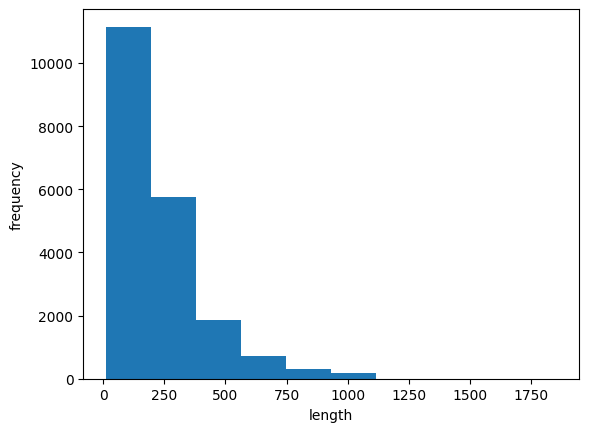

In [9]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

한 쪽으로 치우져 있음  
대부분의 review length는 300 미만  
mean이 median보다 높은 이유는 오른쪽 끝에 아주 큰 data가 있기 때문  

<br/>

review는 대부분 짧아서 이번 practice에서는 median보다 훨씬 짧은 100개의 word만 사용할 것  
하지만 여전히 100 word보다 적은 review가 있음  
이런 review들의 length를 100으로 맞추기 위해 padding이 필요함  
padding을 나타내는 token으로는 0을 assign


수동으로 train set에 있는 20,00개의 sample을 순회하며 length가 100이 되도록 잘라내거나 0으로 padding할 수도 있지만, keras는 이를 위한 sequence data의 length를 맞추는 `pad_sequences()` function을 제공함

<br/>

`pad_sequences()` function을 사용해 `train_input`의 length를 100으로 맞추기

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_seq = pad_sequences(train_input, maxlen=100)

padding 결과 확인
+ `train_seq` shape 확인

In [11]:
print(train_seq.shape)

(20000, 100)


`train_input`은 python list의 array였지만, length를 100으로 맟춘 `train_seq`는 2 dimension array가 됨

<br/>

+ `train_seq`의 첫 번째 sample 확인

In [12]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


이 sample의 앞뒤에 padding value인 0이 없는 것으로 보아 이 sample은 원래 100개보다 많은 word로 이루어져 있었을 것

<br/>

+ sample의 앞부분이 잘렸는지, 뒷부분이 잘렸는지 확인  
`train_input`의 첫 번째 sample의 끝부분 확인













In [13]:
print(train_input[0][-10:])

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


sample의 끝부분이 `train_seq`의 첫 번째 sample의 끝부분과 동일하므로 sample의 앞부분이 잘렸음을 알 수 있음


`pad_sequences()` function은 기본적으로 `maxlen` parameter로 지정한 length보다 sequence의 length가 길 경우 앞부분을 자름  
$\because$ 일반적으로 sequence의 뒷부분의 information이 더 유용하기에


sequence의 뒷부분을 잘라내야 할 경우 `pad_sequences()` function의 `truncating` parameter를 `'pre'`가 아닌 `'post'`로 바꾸어야 함

<br/>

+ `train_seq`의 여섯 번째 sequence 확인

In [14]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


앞부분에 0이 있는 것으로 보아 원래 이 sequence의 length는 100보다 짧았을 것


앞선 sequence의 앞부분이 잘린 이유와 마찬가지로 padding token은 sequence의 앞부분에 추가됨  
sequence의 마지막에 있는 word가 cell의 hidden state에 가장 큰 영향을 주므로 마지막에 padding을 추가하는 방법은 일반적으로 선호되지 않음  
그러나 `pad_sequences()` function의 `pading` parameter를 `'pre'`에서 `'post'`로 바꾸면 뒷부분에 padding을 추가할 수 있음

<br/>

같은 방식으로 validation set의 length도 100으로 맞추기

In [5]:
val_seq = pad_sequences(val_input, maxlen=100)

<br/>  
- - -  
<br/>

### *순환 신경망 만들기*  
keras는 여러 종류의 cell을 제공함  
그 중에 가장 간단한 것은 `SimpleRNN` class  

<br/>

IMDB review data classification은 binary classification이므로 마지막 output layer는 1개의 neuron을 갖고 sigmoid activation function을 사용해야 함

<br/>

`Sequential` class로 RNN 만들기  
+ cell
  + 8개 neuron
  + input shape
    + RNN의 input은 항상 2 dimension
      + sequence(timestep) length
      + 단어 표현  
      one-hot incoding에 필요한 array의 length
  + tanh activation function
+ output layer
  + 1개 neuron
  + sigmoid activation function

In [6]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

`SimpleRNN` class의 `activation` parameter의 기본값이 `'tanh'`이므로 따로 지정하지 않음


`input_shape` parameter의 두 번째 dimension
+ `train_seq`와 `val_seq`에는 한 가지 문제가 있음
  + token을 integer로 변환한 data를 neural network에 주입하면 큰 integer를 가진 token이 큰 activation value를 갖게 됨
  + 그러나 token의 integer value는 어떤 meaning도 가지지 않고 integer 사이에도 어떠한 relationship도 없음  
+ 단순한 integer value를 neural network에 입력하기 위해서는 다른 방식을 찾아야 함
  + integer value에 있는 크기 속성을 없애고 각 integer를 고유하게 표현해야 함
    + one-hot incoding:  
    integer value를 array에서 해당 위치의 element만 1로 하고, 나머지는 모두 0으로 변환
+ `imdb.load_data()` function에서 500개의 word만 사용하도록 지정했기에 고유한 word는 모두 500개이므로, 한 word에 대한 one-hot incoding을 적용하기 위해서는 length 500의 array가 필요함  
&rarr; `input_shape` parameter의 두 번째 dimension이 500이어야 함

<br/>

keras는 one-hot incoding을 위한 utility를 제공함  
&rarr; 수동으로 one-hot incoding에 필요한 array를 만들 필요가 없음  
이 utility는 `keras.utils` package아래의 `to_categorical()` function  
`to_categorical()` function은 integer array를 입력하면 자동으로 one-hot incoding된 array를 return함

<br/>

`train_seq`를 one-hot incoding으로 변환하기

In [7]:
train_oh = keras.utils.to_categorical(train_seq)

`train_oh`의 shape 확인

In [18]:
print(train_oh.shape)

(20000, 100, 500)


integer value 하나마다 모두 500개 dimension으로 변환되었기에 (20000, 100)에서 (20000, 100, 500)으로 변환됨


이렇게 sample data의 shape이 1 dimension의 integer array에서 2 dimension array로 바뀌어야 하므로 `input_shape` parameter를 `(100, 500)`으로 지정함

<br/>

`train_oh`의 첫 번째 sample의 첫 번째 token을 출력해 one-hot incoding 여부 확인

In [19]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


나머지 element가 모두 0인지 확인하기 위해 해당 token의 one-hot incoding array의 총합 계산

In [20]:
print(np.sum(train_oh[0][0]))

1.0


one-hot incoding이 잘 수행되었음

<br/>

같은 방식으로 validation set도 one-hot incoding으로 변환

In [8]:
val_oh = keras.utils.to_categorical(val_seq)

training에 사용할 data 준비를 마침

<br/>

model의 summary 확인

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4081 (15.94 KB)
Trainable params: 4081 (15.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


`SimpleRNN` layer에 전달하는 sample의 shape은 (100, 500)이지만, 이 cell은 마지막 timestep의 hidden state만 출력하므로 output의 shape이 neuron 개수와 같은 8임을 확인할 수 있음

<br/>

cell에 사용된 model parameter 개수 계산
+ input token은 500 dimension의 one-hot incoding array
  + 이 array가 cell의 nueron 8개와 fully-connect되기 때문에 500 * 8 = 4000개의 weighs가 있음
  + cell의 hidden state는 다음 timestep에 사용되기 위해 또 다른 weights와 곱해짐  
  이 hidden state도 cell의 neuron과 fully-connect되므로 8 * 8 = 64
  + neuron 마다 intercepts가 하나씩 있으므로 8개의 intercepts  


&rarr; 4000 + 64 + 8 = 4072개의 model parameter

<br/>  
- - -
<br/>  

### *순환 신경망 훈련하기*  
RNN의 training은 앞서 다루었던 neural networks와 크게 다르지 않음  
model을 compile하고 train하는 전반적인 구조가 동일함  

<br/>  

compile model
+ `RMSprop` optimizer
  + 0.0001 learning rate
+ binary crossentropy loss function
+ accuracy


train model
+ 100 epochs
+ 64 batch size
+ callbacks
  + `ModelCheckpoint`
    + save best model only
  + `EarlyStopping`
    + `patience` parameter `3`으로 지정
    + restore best weights

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data=(val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

서른다섯 번째 epoch에서 early stopping되었음 validation set에 대한 accuracy는 0.8 정도  
&rarr; 매우 뛰어난 성능은 아니지만 감상평을 classify하는 데 어느 정도 성과를 내고 있음

<br/>

loss curve 그리기

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

train loss는 꾸준히 감소하지만 validation loss는 대략 스무 번째 epoch에서 감소가 둔해짐  
&rarr; 적절한 epoch에서 early stopping됨  

<br/>  

- - -  

<br/>  

### *단어 임베딩을 사용하기*

one-hot incoding으로 변환하였는데, one-hot incoding의 단점은 input data가 매우 커진다는 것  
이번 practice에서는 token 1개를 500 dimension으로 늘렸기에 대략 500배 커짐  
이는 train data가 커질수록 더 문제가 될 것


이러한 문제를 해결하기 위해 RNN에서 text를 처리할 때 주로 사용하는 방법이 word embedding  
word embedding은 각 word를 고정된 크기의 real number vector로 바꾸어 줌  

<br/>

word embedding으로 만들어진 vector는 one-hot incoding으로 변환한 vector보다 훨씬 의미있는 value로 채워져 있기에 NLP에서 더 좋은 performance를 내는 경우가 많음


keras는 `keras.layers` package아래 `Embedding` class로 embedding layer를 제공함  
`Embedding` class는 처음에 모든 vector가 random하게 initialize되지만, training을 통해 data에 더 좋은 word imbedding을 학습함


word imbedding의 장점은 input으로 integer data를 받는다는 것  
즉 one-hot encoding으로 변환된 `train_oh`가 아니라 `train_seq`를 사용할 수 있음  
&rarr; memory를 효율적으로 사용할 수 있음

<br/>

one-hot incoding은 sample 하나를 500 dimension으로 늘렸기에 (100, 500)의 shape을 가짐  
word imbedding도 2 dimension array로 늘리지만, one-hot incoding보다 훨씬 작은 size로 word를 잘 표현할 수 있음

<br/>

word embedding layer를 포함하는 RNN model 만들기
+ `Embedding` class
  + 500개의 vocabulary
  + 16 embedding size
  + sequence length

In [ ]:
model2 = keras.sequential()

model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model summary 확인

In [ ]:
model2.summary()

model parameter 개수 계산  
+ embedding layer는 500개의 각 token을 크기가 16인 vector로 변환하기 때문에 500 * 16 = 8000개의 parameter
+ cell은 imbedding vector의 크기가 16이고, 8개의 neuron과 이 vector가 fully-connect되므로 16 * 8 = 128개 parameter
+ hidden state에 곱해지는 weigths 8 * 8 = 64
+ 8 intercepts
+ dense layer에는 9개 weights  


&rarr; 8000 + 128 + 64 + 8 + 9 = 8209

<br/>

train model  
앞선 model과 같음

In [ ]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)

model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

one-hot incoding을 사용한 model과 비슷한 performance를 보여줌  
그러나 cell의 weights 개수는 훨씬 작고 train set의 size도 줄었음

<br/>

loss curve 그리기

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()